In [3]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
import time
import numpy as np
import multiprocessing as mp
from timeit import default_timer as timer
from datetime import timedelta
import seaborn as sns
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

How many cores do I have on this machine?

In [ ]:
mp.cpu_count()

In [15]:
meta = pd.read_csv('data/arxiv_metadata_astroph.csv')
meta

/home/bkh4324/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,identifier,filename,spec,title,datestamp,created,updated,authors,categories,journal,doi,abstract,comments,date_retrieved,filename_parsed
0,oai:arXiv.org:0704.0009,704.001,physics:astro-ph,"The Spitzer c2d Survey of Large, Nearby, Inste...",2010-03-18,2007-04-02,NaN,"Paul Harvey, Bruno Merin, Tracy L. Huard, Luis...",astro-ph,"Astrophys.J.663:1149-1173,2007",10.1086/518646,We discuss the results from the combined IRA...,NaN,2020-03-07 02:10:36.300743,704.001
1,oai:arXiv.org:0704.0017,704.002,physics:astro-ph,Spectroscopic Observations of the Intermediate...,2009-06-23,2007-03-31,NaN,"Nceba Mhlahlo, David H. Buckley, Vikram S. Dhi...",astro-ph,"Mon.Not.Roy.Astron.Soc.378:211-220,2007",10.1111/j.1365-2966.2007.11762.x,Results from spectroscopic observations of t...,NaN,2020-03-07 02:10:36.300743,704.002
2,oai:arXiv.org:0704.0023,704.002,physics:astro-ph,ALMA as the ideal probe of the solar chromosphere,2009-06-23,2007-03-31,NaN,"M. A. Loukitcheva, S. K. Solanki, S. White",astro-ph,"Astrophys.Space Sci.313:197-200,2008",10.1007/s10509-007-9626-1,"The very nature of the solar chromosphere, i...",NaN,2020-03-07 02:10:36.300743,704.002
3,oai:arXiv.org:0704.0044,704.004,physics:astro-ph,Astrophysical gyrokinetics: kinetic and fluid ...,2015-05-13,2007-03-31,2009-05-09,"A. A. Schekochihin, S. C. Cowley, W. Dorland, ...",astro-ph nlin.CD physics.plasm-ph physics.spac...,"ApJS 182, 310 (2009)",10.1088/0067-0049/182/1/310,We present a theoretical framework for plasm...,NaN,2020-03-07 02:10:36.300743,704.004
4,oai:arXiv.org:0704.0048,704.005,physics:astro-ph,Inference on white dwarf binary systems using ...,2008-11-26,2007-03-31,2007-04-03,"Alexander Stroeer, John Veitch, Christian Roev...",gr-qc astro-ph,"Class.Quant.Grav.24:S541-S550,2007",10.1088/0264-9381/24/19/S17,We report on the analysis of selected single...,NaN,2020-03-07 02:10:36.300743,704.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267789,oai:arXiv.org:quant-ph/9903043,quant-ph/9903043,physics:astro-ph,A Possible Anisotropy in Blackbody Radiation V...,2007-05-23,1999-03-12,1999-06-07,T K Rai Dastidar,quant-ph astro-ph hep-th,Mod.Phys.Lett. A14 (1999) 1193-1198,NaN,A non-local gauge symmetry of a complex scal...,NaN,2020-03-07 02:10:36.300743,quant-ph9903043
267790,oai:arXiv.org:quant-ph/9903053,quant-ph/9903053,physics:astro-ph,Father Time. I. Does the Cosmic Microwave Back...,2009-10-31,1999-03-15,1999-10-21,T K Rai Dastidar,quant-ph astro-ph hep-th,Mod.Phys.Lett. A14 (1999) 2499-2505,10.1142/S0217732399002601,The existence of a non-thermodynamic arrow o...,NaN,2020-03-07 02:10:36.300743,quant-ph9903053
267791,oai:arXiv.org:quant-ph/9907088,quant-ph/9907088,physics:astro-ph,On Bures fidelity of displaced squeezed therma...,2008-12-18,1999-07-27,NaN,"Xiang-Bin Wang, C. H. Oh, L. C. Kwek",quant-ph astro-ph,"Phys.Rev.A58:4186,1998",10.1103/PhysRevA.58.4186,Fidelity plays a key role in quantum informa...,NaN,2020-03-07 02:10:36.300743,quant-ph9907088
267792,oai:arXiv.org:solv-int/9404002,solv-int/9404002,physics:astro-ph,Dynamical Systems Accepting the Normal Shift,2008-02-03,1993-04-07,NaN,R. A. Sharipov,solv-int alg-geom astro-ph gr-qc hep-th math.A...,NaN,NaN,Newtonian dynamical systems accepting the no...,NaN,2020-03-07 02:10:36.300743,solv-int9404002


Collect data (abstracts) that we will train doc2vec on:

In [ ]:
data = [abstract.replace('\n', ' ') for abstract in meta['abstract']]
len(data)

Tokenize each abstract. No stopwords are removed.

In [ ]:
%%timeit
train_corpus = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i,_d in enumerate(data)]

In [ ]:
train_corpus[0]

Set up model parameters.

dm = 0 means "distributed bag of words" (PV-DBOW)

dm = 1 means "distributed memory" (PV-DM)

In [ ]:
model = Doc2Vec(vector_size=300,
                alpha=0.025,
                min_alpha=0.001, 
                min_count=1,
                workers=mp.cpu_count(),
                dm=1,
                epochs=40)

model.build_vocab(train_corpus)

Train model for 100 epochs. 

In [ ]:
start = timer()
max_epochs = 100

model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

model.save('d2v.model')
print('Model Saved')
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

In [ ]:
model.save('d2v.model')

Analyze!

## Get labels

In [16]:
acceptable_categories = ['astro-ph',
                         'astro-ph.SR',
                         'astro-ph.CO',
                         'astro-ph.GA',
                         'astro-ph.HE',
                         'astro-ph.EP',
                         'astro-ph.IM']

In [17]:
categories = meta['categories'].str.split(' ')
categories

0                                                [astro-ph]
1                                                [astro-ph]
2                                                [astro-ph]
3         [astro-ph, nlin.CD, physics.plasm-ph, physics....
4                                         [gr-qc, astro-ph]
                                ...                        
267789                         [quant-ph, astro-ph, hep-th]
267790                         [quant-ph, astro-ph, hep-th]
267791                                 [quant-ph, astro-ph]
267792    [solv-int, alg-geom, astro-ph, gr-qc, hep-th, ...
267793    [solv-int, astro-ph, chao-dyn, comp-gas, nlin....
Name: categories, Length: 267794, dtype: object

In [18]:
labels = []

for i, _ in enumerate(categories): 
    for j,_ in enumerate(categories[i]):
        if categories[i][j] in acceptable_categories:
            labels.append(acceptable_categories.index(categories[i][j]))
            break

In [19]:
len(labels)

267794

In [30]:
pd.Series(labels).value_counts()

0    105362
2     41635
1     33328
4     29925
3     29682
5     14669
6     13193
dtype: int64

In [31]:
# We have 7 labels and so 7 colors
colors = ['red', 'green', 'blue', 'purple', 'orange', 'black', 'yellow']
label_colors = []

for i in labels:
    label_colors.append(colors[i])

### Get labels minus astro-ph

In [38]:
acceptable_subcategories = ['astro-ph.SR',
                         'astro-ph.CO',
                         'astro-ph.GA',
                         'astro-ph.HE',
                         'astro-ph.EP',
                         'astro-ph.IM']
len(acceptable_subcategories)

6

In [124]:
subcategory_names = ['Solar and Stellar Astrophysics',
                     'Cosmology and Nongalactic Astrophysics',
                     'Astrophysics of Galaxies',
                     'High Energy Astrophysical Phenomena',
                     'Earth and Planetary Astrophysics',
                     'Instrumentation and Methods for Astrophysics']

In [43]:
categories = meta['categories'].str.split(' ')
categories

0                                                [astro-ph]
1                                                [astro-ph]
2                                                [astro-ph]
3         [astro-ph, nlin.CD, physics.plasm-ph, physics....
4                                         [gr-qc, astro-ph]
                                ...                        
267789                         [quant-ph, astro-ph, hep-th]
267790                         [quant-ph, astro-ph, hep-th]
267791                                 [quant-ph, astro-ph]
267792    [solv-int, alg-geom, astro-ph, gr-qc, hep-th, ...
267793    [solv-int, astro-ph, chao-dyn, comp-gas, nlin....
Name: categories, Length: 267794, dtype: object

Find each paper's author-assigned subcategory. If the paper has none, remove it from the data. We will not plot it. 

In [108]:
labels = []
indexes_to_drop = []

# For each paper
for i, _ in enumerate(categories):
    # For each category
    for j,_ in enumerate(categories[i]):
        assigned = False
        
        # If category is a subcategory, select it as the paper's label (this grabs the first one)
        if categories[i][j] in acceptable_subcategories:
            labels.append(acceptable_subcategories.index(categories[i][j]))
            assigned = True
            break
            
        # If on last category,
        if j == (len(categories[i]) - 1) and not assigned: 
            indexes_to_drop.append(i)            

In [109]:
len(indexes_to_drop)

105283

In [103]:
len(labels)

162511

In [107]:
labels

[4,
 5,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 5,
 5,
 3,
 1,
 4,
 2,
 2,
 5,
 1,
 4,
 4,
 1,
 2,
 4,
 2,
 2,
 6,
 2,
 5,
 4,
 6,
 6,
 3,
 2,
 2,
 2,
 6,
 2,
 2,
 2,
 4,
 2,
 2,
 5,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 5,
 3,
 2,
 5,
 2,
 1,
 1,
 3,
 2,
 4,
 2,
 2,
 6,
 4,
 2,
 6,
 3,
 4,
 4,
 5,
 5,
 5,
 5,
 2,
 2,
 2,
 6,
 2,
 2,
 5,
 2,
 4,
 3,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 6,
 2,
 4,
 6,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 4,
 1,
 3,
 4,
 1,
 4,
 4,
 6,
 1,
 2,
 3,
 1,
 1,
 4,
 3,
 3,
 3,
 2,
 3,
 3,
 1,
 3,
 4,
 4,
 2,
 3,
 2,
 1,
 1,
 2,
 1,
 6,
 2,
 3,
 4,
 4,
 1,
 2,
 3,
 5,
 2,
 2,
 3,
 3,
 4,
 4,
 6,
 2,
 1,
 2,
 1,
 3,
 1,
 1,
 4,
 1,
 1,
 3,
 2,
 4,
 3,
 6,
 3,
 2,
 3,
 3,
 2,
 2,
 3,
 2,
 4,
 1,
 4,
 5,
 1,
 2,
 5,
 3,
 4,
 1,
 4,
 1,
 5,
 4,
 6,
 2,
 3,
 2,
 3,
 2,
 3,
 1,
 2,
 4,
 3,
 2,
 3,
 1,
 3,
 3,
 1,
 2,
 3,
 1,
 5,
 1,
 1,
 2,
 3,
 5,
 1,
 1,
 2,
 3,
 3,
 3,
 2,
 1,
 2,
 3,
 4,
 2,
 1,
 3,
 2,
 1,
 2,
 6,
 4,
 2,
 3,
 2,
 1,
 3,
 2,
 3,
 6,
 3,
 4,
 1,


Load TSNE data:

In [110]:
tsne_data = np.load('tsne_full.npy')
len(tsne_data)

267794

In [111]:
tsne_data_mod = np.delete(tsne_data, indexes_to_drop, axis=0)

In [112]:
len(tsne_data_mod)

162511

In [96]:
tsne_data_mod

array([[  9.271195 , -25.581018 ],
       [  9.570843 , -25.389061 ],
       [  9.438596 , -25.470423 ],
       ...,
       [ 12.133611 ,  17.265772 ],
       [ -4.247407 ,   8.2814245],
       [ -5.0520916,   8.357539 ]], dtype=float32)

THIS IS THE DATA WE WILL PLOT

In [97]:
tsne_data

array([[  9.417695 , -25.48891  ],
       [  9.2686825, -25.58445  ],
       [  9.312196 , -25.55516  ],
       ...,
       [ 12.133611 ,  17.265772 ],
       [ -4.247407 ,   8.2814245],
       [ -5.0520916,   8.357539 ]], dtype=float32)

In [113]:
# We have 7 labels and so 7 colors
colors = ['red', 'green', 'blue', 'purple', 'orange', 'black']
label_colors = []

for i in labels:
    label_colors.append(colors[i])

In [114]:
pd.Series(label_colors).value_counts()

green     41667
red       33334
purple    29932
blue      29689
orange    14684
black     13205
dtype: int64

In [125]:
label_cats = []

for i in labels:
    label_cats.append(subcategory_names[i])

In [126]:
label_cats

['High Energy Astrophysical Phenomena',
 'Earth and Planetary Astrophysics',
 'Solar and Stellar Astrophysics',
 'Cosmology and Nongalactic Astrophysics',
 'Cosmology and Nongalactic Astrophysics',
 'Cosmology and Nongalactic Astrophysics',
 'Cosmology and Nongalactic Astrophysics',
 'Cosmology and Nongalactic Astrophysics',
 'Cosmology and Nongalactic Astrophysics',
 'Earth and Planetary Astrophysics',
 'Earth and Planetary Astrophysics',
 'Astrophysics of Galaxies',
 'Solar and Stellar Astrophysics',
 'High Energy Astrophysical Phenomena',
 'Cosmology and Nongalactic Astrophysics',
 'Cosmology and Nongalactic Astrophysics',
 'Earth and Planetary Astrophysics',
 'Solar and Stellar Astrophysics',
 'High Energy Astrophysical Phenomena',
 'High Energy Astrophysical Phenomena',
 'Solar and Stellar Astrophysics',
 'Cosmology and Nongalactic Astrophysics',
 'High Energy Astrophysical Phenomena',
 'Cosmology and Nongalactic Astrophysics',
 'Cosmology and Nongalactic Astrophysics',
 'Instrume

## Visualize model using PCA

In [ ]:
model = Doc2Vec.load('d2v.model')

## Visualize model using T-SNE

In [2]:
model = Doc2Vec.load('d2v.model')

In [3]:
doc_tags = list(model.docvecs.doctags.keys())
len(doc_tags)

267794

### 10,000

*Since t-SNE scales quadratically in the number of objects N, its applicability is limited to data sets with only a few thousand input objects; beyond that, learning becomes too slow to be practical (and the memory requirements become too large).*

We will only use the first 10,000 samples to save memory and power/time.

In [8]:
x_subset = model[doc_tags][:10000,:]
len(x_subset)

10000

*It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or Truncated SVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high.*

In [14]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(x_subset)
len(pca_result)

10000

In [16]:
len(pca_result[0])

50

In [17]:
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(pca_result)

In [19]:
df = pd.DataFrame(x_tsne, index=doc_tags[:10000], columns=['x', 'y'])

In [77]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="y",
    data=df,
    alpha=0.3
)

NameError: name 'df' is not defined

<Figure size 1152x720 with 0 Axes>

### Full dataset

In [4]:
x_full = model[doc_tags]
len(x_full)

267794

In [8]:
pca_full = PCA(n_components=50)
pca_result_full = pca_full.fit_transform(x_full)
len(pca_result_full)

267794

In [10]:
len(pca_result_full[0])

50

In [11]:
tsne = TSNE(n_components=2, verbose=1)
x_tsne_full = tsne.fit_transform(pca_result_full)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 267794 samples in 2.166s...
[t-SNE] Computed neighbors for 267794 samples in 13303.874s...
[t-SNE] Computed conditional probabilities for sample 1000 / 267794
[t-SNE] Computed conditional probabilities for sample 2000 / 267794
[t-SNE] Computed conditional probabilities for sample 3000 / 267794
[t-SNE] Computed conditional probabilities for sample 4000 / 267794
[t-SNE] Computed conditional probabilities for sample 5000 / 267794
[t-SNE] Computed conditional probabilities for sample 6000 / 267794
[t-SNE] Computed conditional probabilities for sample 7000 / 267794
[t-SNE] Computed conditional probabilities for sample 8000 / 267794
[t-SNE] Computed conditional probabilities for sample 9000 / 267794
[t-SNE] Computed conditional probabilities for sample 10000 / 267794
[t-SNE] Computed conditional probabilities for sample 11000 / 267794
[t-SNE] Computed conditional probabilities for sample 12000 / 267794
[t-SNE] Computed conditional pro

[t-SNE] Computed conditional probabilities for sample 129000 / 267794
[t-SNE] Computed conditional probabilities for sample 130000 / 267794
[t-SNE] Computed conditional probabilities for sample 131000 / 267794
[t-SNE] Computed conditional probabilities for sample 132000 / 267794
[t-SNE] Computed conditional probabilities for sample 133000 / 267794
[t-SNE] Computed conditional probabilities for sample 134000 / 267794
[t-SNE] Computed conditional probabilities for sample 135000 / 267794
[t-SNE] Computed conditional probabilities for sample 136000 / 267794
[t-SNE] Computed conditional probabilities for sample 137000 / 267794
[t-SNE] Computed conditional probabilities for sample 138000 / 267794
[t-SNE] Computed conditional probabilities for sample 139000 / 267794
[t-SNE] Computed conditional probabilities for sample 140000 / 267794
[t-SNE] Computed conditional probabilities for sample 141000 / 267794
[t-SNE] Computed conditional probabilities for sample 142000 / 267794
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 257000 / 267794
[t-SNE] Computed conditional probabilities for sample 258000 / 267794
[t-SNE] Computed conditional probabilities for sample 259000 / 267794
[t-SNE] Computed conditional probabilities for sample 260000 / 267794
[t-SNE] Computed conditional probabilities for sample 261000 / 267794
[t-SNE] Computed conditional probabilities for sample 262000 / 267794
[t-SNE] Computed conditional probabilities for sample 263000 / 267794
[t-SNE] Computed conditional probabilities for sample 264000 / 267794
[t-SNE] Computed conditional probabilities for sample 265000 / 267794
[t-SNE] Computed conditional probabilities for sample 266000 / 267794
[t-SNE] Computed conditional probabilities for sample 267000 / 267794
[t-SNE] Computed conditional probabilities for sample 267794 / 267794
[t-SNE] Mean sigma: 1.041560
[t-SNE] KL divergence after 50 iterations with early exaggeration: 131.792969
[t-SNE] KL divergence after 1000 iterations: 5.982059

Want to color by their author-assigned labels. 

In [22]:
np.save('tsne_full.npy', x_tsne_full)

In [14]:
df_full = pd.DataFrame(x_tsne_full, index=doc_tags, columns=['x', 'y'])
df_full

,x,y
0,9.417695,-25.488911
1,9.268682,-25.584450
2,9.312196,-25.555161
3,9.295492,-25.565912
4,9.332488,-25.539553
...,...,...
267789,-1.007280,13.242110
267790,-4.141513,6.828732
267791,12.133611,17.265772
267792,-4.247407,8.281425


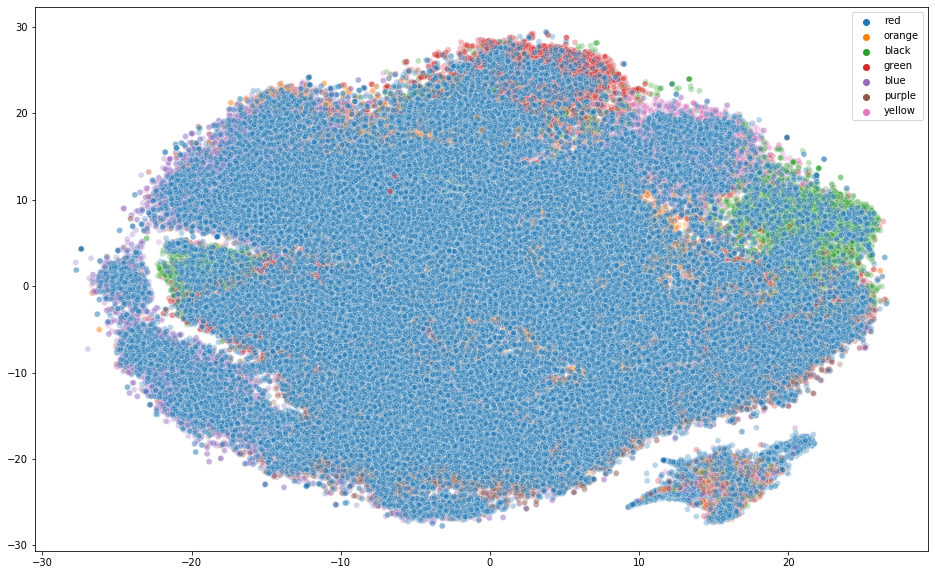

In [32]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=[i[0] for i in tsne_data],
    y=[i[1] for i in tsne_data],
    alpha=0.3,
    hue=label_colors
)

Visualize only the subcategories. We have removed the articles that were only labeled with astro-ph.

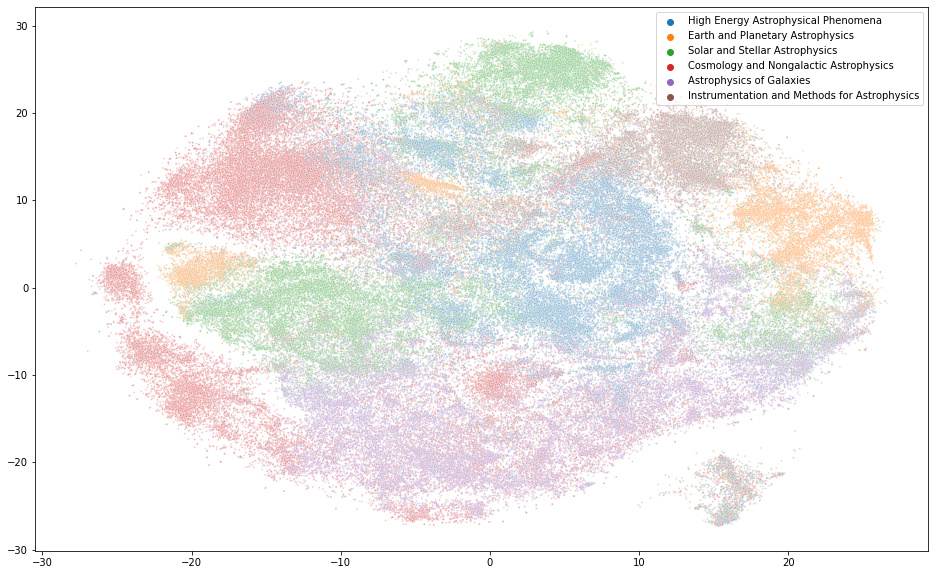

In [135]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=[i[0] for i in tsne_data_mod],
    y=[i[1] for i in tsne_data_mod],
    alpha=0.3,
    s=3,
    hue=label_cats,
    legend='full'
)